# Final Assignment

Author   : Dr Ekaterina Abramova

Document : Preparing to design a "Systematic Trading Algorithm" that will

Task     : make a prediction on whether MSCI EM U$ - PRICE INDEX has positive
           return next day, by treating it as a classification problem.

CLASS LABELS, y (stored in 'target.pkl'):
- buy (+1 i.e. positive return), no trade (0)
- Label has been shifted 1 day ahead i.e. provided label y (from 'target.pkl')
is a result of the operation: y = y_original.shift(-1)
- Example: for date 2000-01-03, the corresponding label indicates what happened
to the Index the next day (i.e. next day 2000-01-04 index went up. This label
is stored against 2000-01-03 in order to learn day ahead prediction)
- Summary: you do not need to shift the label, both X and y are already alinged.

DATA (X, stored in 'design_matrix.pkl'):
- The design matrix (X) is provided for you & contains TIME SERIES DATA:
  - returns of world indices
  - returns of commoditiy indices
  - global interest rates
  - bonds
  - technical indicators data
  - dummy variables


The data does not contain any features representing individual stocks.
The data is arleady clean, there are no missing values and price data has been
converted to returns to make it stationary.

Any column that contains only 0 or 1 is a dummy variable.
Features are in different units.

Note: that the feature names have been anonomysed because this is a real life
dataset used for a trading algorithm.

TASKS:
Carry out the following steps for your systematic algorithm analysis:

1) Split the data into train, validate, test sets.
- Keep the LAST 3 months worth of data for TEST data: 65 most recent days
- The rest split into 80% TRAIN (1st part of the data) and 20% VALIDATION
  (remaining part of the data except test data)
Think carefully about the kind of data you're working with: TIME SERIES DATA
Will your data need to be randomly shuffled during the train/val/test split?
Always fix random number generator for reproducibility in case you choose to use
train_test_split() function

2) Dimensionality of your Design Matrix is rather high (>500 features). Ahead of
using a classifier of your choice (e.g. SVM), reduce the feature from D to M,
where M is some smaller numer that you decide upon based on variance analysis.

Decide on which features should be reduced with PCA (i.e. all of them or only
some of them?) and obtain the principal componenet scores (new data points)
- plot correlation matrix of train data as a heatmap to decide if PCA will help
- are there any columns with many 0s? Will these be helpful to PCA?
  If not, will you remove them alltogether or set them aside for later use?
- should data be centered ahead of PCA?
- should data be scaled in this case?
Using variance analysis decide on how many PCs to keep
Obtain a new design matrix based on joining features from:
- the scores obtained from the PCA
- any original design matrix's features you may have decided to set aside
  (and not process through the PCA but keep for analysis)

## 1. Imports

In [11]:
import sys
import os 
# Use legacy version 
os.environ['TF_USE_LEGACY_KERAS'] = '1'
# Disable TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer  # TF
from sklearn.feature_extraction.text import TfidfTransformer  # TFIDF

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score

In [12]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
#import tensorflow.keras.optimizers.legacy.Adam import Adam  # Use legacy version for M2 chips
from tensorflow.keras.callbacks import EarlyStopping

# for grid search with LSTM
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import TimeSeriesSplit

# For AutoML
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband

In [13]:
print(tf.__version__)

2.16.1


## 2. Data Preprocessing

In [14]:
# Set the seeds
import random

SEED = 42

# source: https://stackoverflow.com/a/66343730
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds(SEED)

In [15]:
# %% READ IN DATA AND SPLIT INTO TRAIN / VALIDATE / TEST
'''
Note for loading: your datasets are in a format .pkl
'''
# filename = 'design_matrix.pkl'
# with open(filename, 'rb') as file:
#     X = pickle.load(file)
with open('design_matrix.csv') as f:
    X = pd.read_csv(f)

with open('target.csv') as f:
    y = pd.read_csv(f).squeeze()

# filename = 'target.pkl'
# with open(filename, 'rb') as file:
#     y = pickle.load(file).squeeze()  # convert y from DataFrame to a Series


In [16]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We have to separate out the dummy variables

In [17]:
# Make sure to use shuffle=False to prevent shuffling time series data
X_train_val, X_test_orig, y_train_val, y_test_orig = train_test_split(X, y, test_size=65 / X.shape[0], random_state=42, shuffle=False)
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42, shuffle=False)

In [18]:
# Dummy columns are identified by looking at their unique values which should be 0 and 1
dummy_cols = [col for col in X.columns if set(pd.unique(X[col])) == set([0, 1])]
numeric_cols = [col for col in X.columns if col not in dummy_cols]
print('The last 10 dummy columns are: ', dummy_cols[-10:])

The last 10 dummy columns are:  ['23', '24', '25', '134', '135', '136', '179', '180', '208', '245']


In [19]:
# Load the numeric columns into separate dataframes
X_train_num = X_train_orig[numeric_cols]
X_val_num = X_val_orig[numeric_cols]
X_test_num = X_test_orig[numeric_cols]

In [20]:
# Load the categorical variables into separate dataframes
X_train_cat = X_train_orig[dummy_cols]
X_val_cat = X_val_orig[dummy_cols]
X_test_cat = X_test_orig[dummy_cols]

In [21]:
# Compute the mean and standard deviation of the training set 
# This will be used to center the data before PCA
mu_X_train = X_train_num.mean(axis=0)
sd_X_train = X_train_num.std(axis=0)
print(f'Number of NaN values in the mean and sd: {mu_X_train.isna().sum()}, {sd_X_train.isna().sum()}')

Number of NaN values in the mean and sd: 0, 0


In [22]:
X_train_num.head()

,26,27,28,29,30,31,32,33,34,35,...,548,549,550,551,552,553,554,555,556,557
0,0.000267,0.021,0.004,0.272,-0.004,-0.010,-0.011,-0.009,2.11,-0.054,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.138961,0.010,0.002,-0.017,0.006,0.002,0.002,0.001,2.43,-0.106,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.168044,0.019,0.000,-0.172,0.035,0.033,0.028,0.032,2.05,-0.336,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.212169,0.017,0.006,-0.195,0.037,0.037,0.026,0.037,2.58,-0.340,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.085817,0.021,0.006,-0.280,0.050,0.044,0.035,0.045,1.64,-0.397,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print('Verifying that the number of columns is still equal:')
X_train_num.shape, X_val_num.shape, X_test_num.shape

Verifying that the number of columns is still equal:


((4981, 525), (1246, 525), (65, 525))

In [24]:
# Standardise the data before applying PCA
# I decide to also scale the data, as the features have different units (according to the assignment instructions)
X_train_stzd = (X_train_num - mu_X_train) / sd_X_train
X_val_stzd = (X_val_num   - mu_X_train) / sd_X_train
X_test_stzd  = (X_test_num  - mu_X_train) / sd_X_train

# We want to keep the original scale of the features, so we 
# only center the data before applying PCA
# -> Not applicable since the features have different units
X_train_centred = (X_train_num - mu_X_train) 
X_val_centred = (X_val_num   - mu_X_train) 
X_test_centred  = (X_test_num  - mu_X_train)

In [25]:
X_train_stzd.head()

,26,27,28,29,30,31,32,33,34,35,...,548,549,550,551,552,553,554,555,556,557
0,-0.001483,0.321236,0.203575,5.744464,-0.116345,-0.373945,-0.386829,-0.305219,1.053928,-0.090612,...,0.169933,-0.146301,0.261858,0.248533,1.878248,0.158729,-0.130772,-0.001906,-0.19422,0.0
1,-1.007089,0.153497,0.101884,-0.353443,0.241050,0.110671,0.105560,0.064917,1.213098,-0.167405,...,0.169933,-0.146301,0.261858,0.248533,1.878248,0.158729,-0.130772,-0.001906,-0.19422,0.0
2,-1.217148,0.290738,0.000194,-3.623947,1.277494,1.362593,1.090338,1.212336,1.024083,-0.507070,...,0.169933,-0.146301,0.261858,0.248533,1.878248,0.158729,-0.130772,-0.001906,-0.19422,0.0
3,-1.535850,0.260240,0.305265,-4.109248,1.348973,1.524132,1.014586,1.397404,1.287709,-0.512977,...,0.169933,-0.146301,0.261858,0.248533,1.878248,0.158729,-0.130772,-0.001906,-0.19422,0.0
4,-0.623244,0.321236,0.305265,-5.902750,1.813587,1.806824,1.355471,1.693512,0.820146,-0.597155,...,0.169933,-0.146301,0.261858,0.248533,1.878248,0.158729,-0.130772,-0.001906,-0.19422,0.0


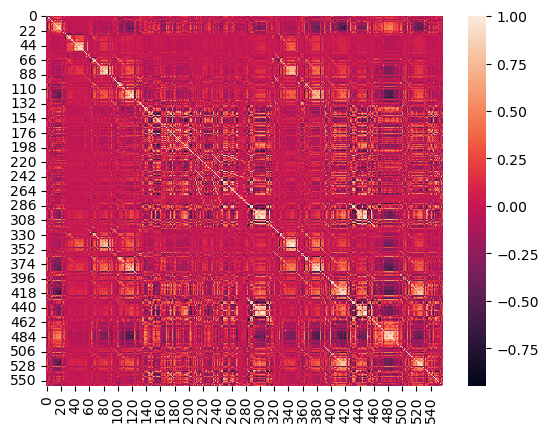

In [26]:
# %% PCA
# -----------------------------------------------------------------------------
# Plot correlation heatmap
corr_X_train = X_train_orig.corr()
sns.heatmap(corr_X_train)
plt.show()

This heatmap shows us that most features are uncorrelated to one another (red color), although there are someo groups of features that are strongly positively correlated (bright orange) and strongly negatively correlated (dark purple).

Let's look at the correlations with the target feature exclusively, to investigate whether any of the features could be strong predictors of the target feature's value: 

In [27]:
corr_matrix = pd.concat((X_train_orig, y_train_orig), axis=1).corr()

In [28]:
# Now, focus on just the correlations with the target feature
target_corr = corr_matrix.iloc[:, -1].sort_values(ascending=False)[1:]
target_corr.values.shape

(558,)

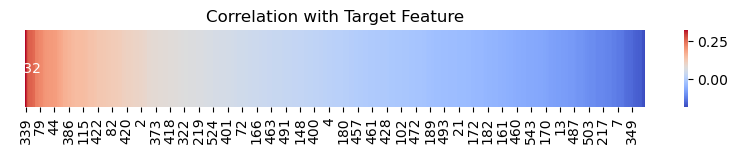

In [29]:
# Create a DataFrame to visualize as a heatmap
target_corr_df = target_corr.to_frame().T  # Transpose to make it a 2D DataFrame

plt.figure(figsize=(10, 1)) 
sns.heatmap(target_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Correlation with Target Feature")
plt.yticks([])  # hide the yticks
plt.show()

We note that there are only very weak correlations with the target feature. This means that there are no dominant features in predicting the value of the target variable (i.e. whether to invest or not).

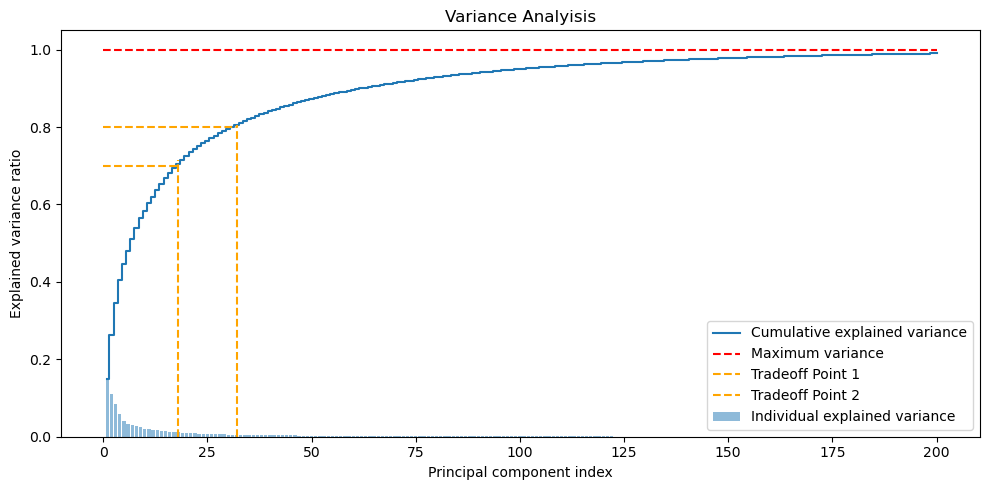

In [30]:
pca = PCA(n_components=X_train_stzd.shape[1])
pca.fit(X_train_stzd)

# Variance Analysis
limit = 200
explained_variance_ratio = pca.explained_variance_ratio_[:limit]
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)[:limit]

# Plotting the Explained Variance
plt.figure(figsize=(10, 5))
plt.bar(range(1, limit+1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, limit+1), cumulative_variance_ratio, where='mid', label='Cumulative explained variance')

plt.hlines(1, xmin=0, xmax=200, color='r', ls='dashed', label='Maximum variance')
plt.hlines(0.8, xmin=0, xmax=32, color='orange',ls='dashed',label='Tradeoff Point 1')
plt.vlines(32, ymin=0, ymax=cumulative_variance_ratio[31], color='orange',ls='dashed')
plt.hlines(0.7, xmin=0, xmax=18, color='orange',ls='dashed',label='Tradeoff Point 2')
plt.vlines(18, ymin=0, ymax=cumulative_variance_ratio[18], color='orange',ls='dashed')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
#plt.scatter([32], [cumulative_variance_ratio[31]], marker='x', color='orange', label = 'Tradeoff point', s=100)
plt.legend(loc='best')
plt.title('Variance Analyisis')
plt.tight_layout()
plt.show()

35 Components seems to be a good tradeoff between variance and number of principal components. Let's use PCA to projecet the features onto 35 principal components.

In [31]:
# decide on what data should be passed through PCA
n_components = 35
pca = PCA(n_components=n_components, random_state=42)

# fit (find PCs) and transform (find Z scores) train data
Z_train_pca = pd.DataFrame(pca.fit_transform(X_train_stzd))
Z_val_pca = pd.DataFrame(pca.transform(X_val_stzd))
Z_test_pca = pd.DataFrame(pca.transform(X_test_stzd))

Now we'll merge the standardised, numeric columns that have been transformed with PCA with the original dummy columns.

Let's first check the shapes of both dataframes

In [32]:
Z_train_pca.shape, Z_val_pca.shape, Z_test_pca.shape

((4981, 35), (1246, 35), (65, 35))

The number of rows still matches (as expected), so we can merge both dataframes horizontally.

In [33]:
X_train_all = pd.concat([Z_train_pca, X_train_cat], axis=1)
X_train_all.shape

(4981, 68)

In [34]:
X_val_all = pd.concat([Z_val_pca.reset_index(drop=True), X_val_cat.reset_index(drop=True)], axis=1)
X_val_all.shape

(1246, 68)

In [35]:
X_test_all = pd.concat([Z_test_pca.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)
X_test_all.shape

(65, 68)

## 3. Model Selection (PCA Data)

In this section an SVM model and a neural network model (LSTM netowrk) are trained on the data which is projected onto 35 principal components. The models are evaluated on a holdout test set in terms of accuracy and F1 score. The **F1 score is chosen as main evaluation metric**, becuase it's particularly suitable as it balances the precision (not losing money on wrong trades) and recall (capturing a significant number of profitable trades) using a harmonic mean.

### 3.1 Support Vector Machine (SVM)

In [30]:
X_train_all.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,134,135,136,179,180,208,245
0,-3.095846,-8.287809,-9.974769,-2.529174,2.628092,3.620249,5.160130,-2.454998,-0.017103,1.483164,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-2.443752,-8.687528,-9.272599,-1.505769,3.419087,4.026160,5.016877,-2.888841,-0.837191,1.008493,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.437805,-9.046677,-8.091486,-2.165929,5.131275,3.305528,0.758934,-2.490563,3.023133,-0.854305,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.210163,-9.277682,-7.272531,-2.306955,5.496984,2.996165,-0.112443,-2.986139,3.763755,-2.371087,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.041016,-9.280833,-7.395531,-2.466197,5.547679,2.709073,-0.423544,-2.594320,4.210611,-2.416084,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly'] 
}

In [32]:
svc = SVC()

# Use TimeSeriesSplit to enable to use corss validation below,
# while respecting the order of the time series!
tscv = TimeSeriesSplit(n_splits=5)

# Setup GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=tscv, scoring='f1', verbose=10)

scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_all.values)
X_val_all_scaled = scaler.transform(X_val_all.values)
X_test_all_scaled = scaler.transform(X_test_all.values)

# Fit the model on the PCA reduced data in combination with the original dummy columns
grid_search.fit(X_train_all_scaled, y_train_orig.values)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 1/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.037 total time=   0.1s
[CV 2/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 2/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.775 total time=   0.1s
[CV 3/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 3/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.729 total time=   0.2s
[CV 4/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 4/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.666 total time=   0.4s
[CV 5/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 5/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.705 total time=   0.6s
[CV 1/5; 2/24] START C=0.1, gamma=scale, kernel=linear..........................
[CV 1/5; 2/24] END C=0.1, gamma=scale

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='f1', verbose=10)

In [33]:
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
best_model = grid_search.best_estimator_
best_model

Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Best score: 0.592508868030974


SVC(C=1, gamma='auto', kernel='poly')

**Evaluating the model on the test set**

In [34]:
# Build a dataframe to keep track of the algorithm's results
test_results = pd.DataFrame({'Algorithm': [], 'PCA?': [], 'F1 Score' : [], 'Accuracy': []})

In [35]:
"""
Add the test results to a dataframe
"""
def add_test_result(algo, used_pca, f1, acc):
    test_results.loc[len(test_results)] = [algo, used_pca, f1, acc]

In [48]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_type, PCA):
    if not isinstance(X_test, np.ndarray):
        X_test = X_test.values

    y_pred = model.predict(X_test)
    if set(np.unique(y_pred)) != set([0, 1]):  
        y_pred = (y_pred > 0.5).astype(np.float64)

    #r2 = model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    # Compute the R^2 score of the best model on the test set
    # print('R Squared (test set): ', r2)
    print('\nF1 Score  (test set): ', round(f1, 2))
    print('Accuracy  (test set): ', round(acc,2))

    print('')
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))
    
    add_test_result(model_type, PCA, f1, acc)

In [37]:
# Combine the training and validation set to trian the final model
X_all_combined = np.concatenate((X_train_all_scaled, X_val_all_scaled), axis=0)
y_all_combined = np.concatenate((y_train_orig, y_val_orig), axis=0)

best_model.fit(X_all_combined, y_all_combined)

SVC(C=1, gamma='auto', kernel='poly')

In [38]:
evaluate_model(best_model, X_all_combined, y_all_combined, X_test_all_scaled, y_test_orig, 'SVC', True)


F1 Score  (test set):  0.93
Accuracy  (test set):  0.92

              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.92        31
     Class 1       0.94      0.91      0.93        34

    accuracy                           0.92        65
   macro avg       0.92      0.92      0.92        65
weighted avg       0.92      0.92      0.92        65



In [ ]:
test_results

### 3.2 LSTM Model

In this section, a Long-Short Term Memory (LSTM) neural network will be trained, as this model is known for having strong performance on time series data.

#### Prepare the data

Check that the tensorflow version is up to date.

In [35]:
print(tf.__version__)

2.16.1


#### Hyperband Optimisation

The Hyperband tuner is used to tune the hyperparameters of the LSTM model.

First, the LSTM model is converted to a class to extend the HyperModel class, as this allows it to be used in conjunction with the HyperBand tuner.

In [37]:
nb_timesteps=1  # Only give one day of data as input for each prediction to give a fair comparison with the svm
nb_features = X_train_all.shape[1]
nb_features

68

In [38]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(1, nb_features)))  # 1 time step (1 day) with nb_features explanatory variables (batch size is None)
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            #input_shape=self.input_shape,
            return_sequences=False,  
            activation = hp.Choice("activation", ["relu", "tanh"])
        ))
        model.add(Dropout(rate=hp.Float(
            'dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05,
        )))
        model.add(Dense(units=1, activation='sigmoid')) 
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam (
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

In [42]:
# Before feeding the data to the LSTM, we need to convert it to a 3D array of shape (nb_samples, nb_timesteps, nb_features) 
# We only use 1 time step (i.e. day) as input to the prediciton to have a fair comparison compared to the SVM
scaler = StandardScaler()
X_train_lstm = np.reshape(scaler.fit_transform(X_train_all.values), (-1, nb_timesteps, nb_features))
y_train_lstm = y_train_orig
X_val_lstm = np.reshape(scaler.transform(X_val_all.values), (-1, nb_timesteps, nb_features))
y_val_lstm = y_val_orig
X_test_lstm = np.reshape(scaler.transform(X_test_all.values), (-1, nb_timesteps, nb_features))
y_test_lstm = y_test_orig

In [535]:
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape

((4981, 1, 68), (1246, 1, 68), (65, 1, 68))

In [43]:
lstm_hypermodel = LSTMHyperModel(input_shape=(nb_timesteps, nb_features))

tuner = Hyperband(
    lstm_hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='pca_data'
)

Reloading Tuner from hyperband/pca_data/tuner0.json


In [541]:
# Find the best set of hyperparameters by using keras_tuner
tuner.search(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    validation_data=(X_val_lstm, y_val_lstm),
    #callbacks=[early_stopping]
)

In [542]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')} 
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 64 
and the optimal learning rate for the optimizer is 0.0001.



In [543]:
# Build the model with the best hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

# Train the model on both the training and validation data
X_train_val_lstm = np.concatenate((X_train_lstm, X_val_lstm), axis=0)
y_train_val_lstm = pd.concat((y_train_lstm, y_val_lstm), axis=0)

print(X_train_val_lstm.shape)
print(y_train_val_lstm.shape)

(6227, 1, 68)
(6227,)


In [545]:
# Stop when the validation loss doesn't decrease anymore
early_stopping = EarlyStopping(
        mode='max',
        monitor='accuracy', 
        min_delta=0.01, 
        patience=5, 
        verbose=1, 
        restore_best_weights=True
    )
model.fit(X_train_val_lstm, y_train_val_lstm, verbose=1, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.5476 - loss: 0.6854
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6989 - loss: 0.6384
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7438 - loss: 0.6000
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7627 - loss: 0.5640
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7779 - loss: 0.5312
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7846 - loss: 0.5067
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8070 - loss: 0.4825
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8071 - loss: 0.4643
Epoch 9/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8150 - loss: 0.4457
Epoch 10/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8168 - loss: 0.4290
Epoch 11/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8359 - loss: 0.4050
Epoch 12/100
195/195 ━━━━━━━━

In [546]:
evaluate_model(model, X_train_val_lstm, y_train_val_lstm, X_test_lstm, y_test_lstm, 'LSTM', True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step

F1 Score  (test set):  0.84
Accuracy  (test set):  0.82

              precision    recall  f1-score   support

     Class 0       0.88      0.71      0.79        31
     Class 1       0.78      0.91      0.84        34

    accuracy                           0.82        65
   macro avg       0.83      0.81      0.81        65
weighted avg       0.83      0.82      0.81        65



We see that the LSTM performs strongly, achieving an F1 score of 0.84 and an accuracy of 0.82 on the test set. However, on the PCA data, the SVM performs better. This might be due to the fact tha the LSTM could use the non-reduced data to its advantage, whereas the SVM benefits from lower dimensional data, as it has less parameters to tune than the LSTM does.

### 3.3 Multi-Layer Perceptron (MLP)

As a third model, a multi-layer perceptron (MLP) model is chose, which is a fully connected, vanilla neural network. Some dropout layers are added to improve the generalisation rate beyond the training data.

#### Hyperband Optimisation

The Hyperband tuner is used to tune the hyperparameters of the LSTM model.

First, the LSTM model is converted to a class to extend the HyperModel class, as this allows it to be used in conjunction with the HyperBand tuner.

In [55]:
nb_timesteps=1  # Only give one day of data as input for each prediction to give a fair comparison with the svm
nb_features = X_train_all.shape[1]
nb_features

68

In [56]:
class MLPHyperModel(HyperModel):
    def __init__(self, input_shape):
        pass
        
    def build(self, hp):
        rate = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
        units = hp.Int('units', min_value=32, max_value=512, step=32)
        model = Sequential()
        # model.add(Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(rate=rate))
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(rate=rate))
        model.add(Dense(units, activation='relu'))
        model.add(Dense(units=1, activation='sigmoid'))
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam (
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

In [57]:
scaler = StandardScaler()
X_train_lstm = scaler.fit_transform(X_train_all.values)
y_train_lstm = y_train_orig
X_val_lstm = scaler.transform(X_val_all.values)
y_val_lstm = y_val_orig
X_test_lstm = scaler.transform(X_test_all.values)
y_test_lstm = y_test_orig

In [58]:
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape

((4981, 68), (1246, 68), (65, 68))

In [59]:
mlp_hypermodel = MLPHyperModel(input_shape=(nb_timesteps, nb_features))

tuner = Hyperband(
    mlp_hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='MLP_pca'
)

Reloading Tuner from hyperband/MLP_pca/tuner0.json


In [60]:
# Find the best set of hyperparameters by using keras_tuner
tuner.search(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    validation_data=(X_val_lstm, y_val_lstm),
    #callbacks=[early_stopping]
)

In [44]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal nb of units is {best_hps.get('units')}.""")

The hyperparameter search is complete. The optimal nb of units is 192.


In [61]:
# Build the model with the best hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

# Train the model on both the training and validation data
X_train_val_lstm = np.concatenate((X_train_lstm, X_val_lstm), axis=0)
y_train_val_lstm = pd.concat((y_train_lstm, y_val_lstm), axis=0)

print(X_train_val_lstm.shape)
print(y_train_val_lstm.shape)

(6227, 68)
(6227,)


In [670]:
# Stop when the validation loss doesn't decrease anymore
early_stopping = EarlyStopping(
        mode='max',
        monitor='accuracy', 
        min_delta=0.01, 
        patience=5, 
        verbose=1, 
        restore_best_weights=True
    )
model.fit(X_train_val_lstm, y_train_val_lstm, verbose=1, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step - accuracy: 0.7030 - loss: 0.6354
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8283 - loss: 0.3877
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8532 - loss: 0.3359
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8494 - loss: 0.3382
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8627 - loss: 0.3033
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8779 - loss: 0.2838
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8896 - loss: 0.2667
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9005 - loss: 0.2416
Epoch 9/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9003 - loss: 0.2461
Epoch 10/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8963 - loss: 0.2472
Epoch 11/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9075 - loss: 0.2209
Epoch 12/100
195/195 ━━━━━━━

In [671]:
evaluate_model(model, X_train_val_lstm, y_train_val_lstm, X_test_lstm, y_test_lstm, 'MLP', True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step

F1 Score  (test set):  0.97
Accuracy  (test set):  0.97

              precision    recall  f1-score   support

     Class 0       1.00      0.94      0.97        31
     Class 1       0.94      1.00      0.97        34

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65



## 4. Model Selection (Original Data)

In this section, it is investigated whether the models perform better when trained on original data rather than on the PCA reduced data.

### 4.1 Support Vector Machine (SVM)

In [482]:
svc = SVC()

# Use TimeSeriesSplit to enable to use corss validation below,
# while respecting the order of the time series!
tscv = TimeSeriesSplit(n_splits=5)

# Setup GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=tscv, scoring='f1', verbose=10)

scaler = StandardScaler()
X_train_orig_scaled = scaler.fit_transform(X_train_orig.values)
X_val_orig_scaled = scaler.transform(X_val_orig.values)
X_test_orig_scaled = scaler.transform(X_test_orig.values)

# Fit the model on the PCA reduced data in combination with the original dummy columns
grid_search.fit(X_train_orig_scaled, y_train_orig.values)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 1/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.344 total time=   0.5s
[CV 2/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 2/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.770 total time=   0.6s
[CV 3/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 3/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.737 total time=   1.5s
[CV 4/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 4/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.655 total time=   2.6s
[CV 5/5; 1/24] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 5/5; 1/24] END C=0.1, gamma=scale, kernel=rbf;, score=0.631 total time=   3.8s
[CV 1/5; 2/24] START C=0.1, gamma=scale, kernel=linear..........................
[CV 1/5; 2/24] END C=0.1, gamma=scale

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='f1', verbose=10)

In [484]:
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.6326261564341851


In [485]:
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
best_model

Best parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


SVC(C=0.1, gamma='auto')

**Evaluating the model on the test set**

In [486]:
# Combine the training and validation set to trian the final model
X_orig_combined = np.concatenate((X_train_orig_scaled, X_val_orig_scaled), axis=0)
y_orig_combined = np.concatenate((y_train_orig, y_val_orig), axis=0)

best_model.fit(X_orig_combined, y_orig_combined)

SVC(C=0.1, gamma='auto')

In [490]:
evaluate_model(best_model, X_orig_combined, y_orig_combined, X_test_orig_scaled, y_test_orig, 'SVC', True)


F1 Score  (test set):  0.81
Accuracy  (test set):  0.83

              precision    recall  f1-score   support

     Class 0       0.74      1.00      0.85        31
     Class 1       1.00      0.68      0.81        34

    accuracy                           0.83        65
   macro avg       0.87      0.84      0.83        65
weighted avg       0.88      0.83      0.83        65



In [491]:
test_results

,Algorithm,PCA?,F1 Score,Accuracy
0,SVC,True,0.925373,0.923077
1,LSTM,True,0.627451,0.707692
2,SVC,True,0.807018,0.830769


The SVM performs worse on the  original data than it does on the PCA reduced data. This shows that the SVC can leverage the reduced dimensionality of the latter data set.

### 4.2 LSTM Network

In this section, a Long-Short Term Memory (LSTM) will be trained on the original data.

#### Prepare the data

Check that the tensorflow version is up to date.

In [492]:
print(tf.__version__)

2.16.1


#### Hyperband Optimisation

The Hyperband tuner is used to tune the hyperparameters of the LSTM model.

First, the LSTM model is converted to a class to extend the HyperModel class, as this allows it to be used in conjunction with the HyperBand tuner.

In [41]:
nb_timesteps=1  # Only give one day of data as input for each prediction to give a fair comparison with the svm
nb_features = X_train_orig.shape[1]
nb_features

558

In [42]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(1, nb_features)))  # 1 time step (1 day) with nb_features explanatory variables (batch size is None)
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            #input_shape=self.input_shape,
            return_sequences=False,  
            activation = hp.Choice("activation", ["relu", "tanh"])
        ))
        model.add(Dropout(rate=hp.Float(
            'dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05,
        )))
        model.add(Dense(units=1, activation='sigmoid'))  
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam (
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

In [43]:
# Before feeding the data to the LSTM, we need to convert it to a 3D array of shape (nb_samples, nb_timesteps, nb_features) 
# We only use 1 time step (i.e. day) as input to the prediciton to have a fair comparison compared to the SVM
scaler = StandardScaler()
X_train_lstm = np.reshape(scaler.fit_transform(X_train_orig.values), (-1, nb_timesteps, nb_features))
y_train_lstm = y_train_orig
X_val_lstm = np.reshape(scaler.transform(X_val_orig.values), (-1, nb_timesteps, nb_features))
y_val_lstm = y_val_orig
X_test_lstm = np.reshape(scaler.transform(X_test_orig.values), (-1, nb_timesteps, nb_features))
y_test_lstm = y_test_orig

In [44]:
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape

((4981, 1, 558), (1246, 1, 558), (65, 1, 558))

In [45]:
lstm_hypermodel = LSTMHyperModel(input_shape=(nb_timesteps, nb_features))

tuner = Hyperband(
    lstm_hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='orig_data'
)

Reloading Tuner from hyperband/orig_data/tuner0.json


In [46]:
# Find the best set of hyperparameters by using keras_tuner
tuner.search(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    validation_data=(X_val_lstm, y_val_lstm),
    #callbacks=[early_stopping]
)

In [79]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("The best hyperparameters are:")
for hp_name, value in best_hps.values.items():
    print(f"{hp_name}: {value}")

The best hyperparameters are:
units: 128
activation: tanh
dropout: 0.35000000000000003
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0


In [81]:
# Build the model with the best hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

# Train the model on both the training and validation data
X_train_val_lstm = np.concatenate((X_train_lstm, X_val_lstm), axis=0)
y_train_val_lstm = pd.concat((y_train_lstm, y_val_lstm), axis=0)

print(X_train_val_lstm.shape)
print(y_train_val_lstm.shape)

(6227, 558)
(6227,)


In [524]:
hypermodel = LSTMHyperModel(input_shape=(nb_timesteps, nb_features))

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='orig_data'
)

Reloading Tuner from hyperband/orig_data/tuner0.json


In [161]:
# Find the best set of hyperparameters by using keras_tuner
tuner.search(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stopping]
)

Trial 84 Complete [00h 00m 28s]
val_accuracy: 0.6532905101776123

Best val_accuracy So Far: 0.6532905101776123
Total elapsed time: 00h 50m 29s


The best accuracy on the validation we achieve is 0.65. Let's validate the performance of the best model on the test set.

In [528]:
# Before feeding the data to the LSTM, we need to convert it to a 3D array of shape (nb_samples, nb_timesteps, nb_features) 
# We only use 1 time step (i.e. day) as input to the prediciton to have a fair comparison compared to the SVM
X_train_lstm = np.reshape(scaler.fit_transform(X_train_orig.values), (-1, nb_timesteps, nb_features))
y_train_lstm = y_train_orig
X_val_lstm = np.reshape(scaler.transform(X_val_orig.values), (-1, nb_timesteps, nb_features))
y_val_lstm = y_val_orig
X_test_lstm = np.reshape(scaler.transform(X_test_orig.values), (-1, nb_timesteps, nb_features))
y_test_lstm = y_test_orig

In [529]:
# Build the model with the best hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

# Train the model on both the training and validation data
X_train_val_lstm = np.concatenate((X_train_lstm, X_val_lstm), axis=0)
y_train_val_lstm = pd.concat((y_train_lstm, y_val_lstm), axis=0)

print(X_train_val_lstm.shape)
print(y_train_val_lstm.shape)

(6227, 1, 558)
(6227,)


In [530]:
# Stop when the validation loss doesn't decrease anymore
early_stopping = EarlyStopping(
        mode='max',
        monitor='accuracy', 
        min_delta=0.01, 
        patience=5, 
        verbose=1, 
        restore_best_weights=True
    )
model.fit(X_train_val_lstm, y_train_val_lstm, verbose=1, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.6609 - loss: 0.6264
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8300 - loss: 0.4495
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8578 - loss: 0.3738
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8920 - loss: 0.3209
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9060 - loss: 0.2754
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9242 - loss: 0.2418
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9360 - loss: 0.2036
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9442 - loss: 0.1874
Epoch 9/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9450 - loss: 0.1791
Epoch 10/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9488 - loss: 0.1617
Epoch 11/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9529 - loss: 0.1460
Epoch 12/100
195/195 ━━━━━━━━

In [531]:
evaluate_model(model, X_train_val_lstm, y_train_val_lstm, X_test_lstm, y_test_lstm, 'LSTM', True)

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/stepWARNING:tensorflow:5 out of the last 34 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3b8535ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step

F1 Score  (test set):  0.96
Accuracy  (test set):  0.95

              precision    recall  f1-score   support

     Class 0       0.94      0.97      0.95        31
     Class 1       0.97      0.94   

It can be noted that using the non-reduced training data is strongly beneficial for the LSTM's performance.

### 4.3 Multilayer Perceptron (MLP)

As a third model, a multi-layer perceptron (MLP) model is chose, which is a fully connected, vanilla neural network. Some dropout layers are added to improve the generalisation rate beyond the training data.

#### Hyperband Optimisation

The Hyperband tuner is used to tune the hyperparameters of the LSTM model.

First, the LSTM model is converted to a class to extend the HyperModel class, as this allows it to be used in conjunction with the HyperBand tuner.

In [47]:
nb_timesteps=1  # Only give one day of data as input for each prediction to give a fair comparison with the svm
nb_features = X_train_all.shape[1]
nb_features

68

In [48]:
class MLPHyperModel(HyperModel):
    def __init__(self, input_shape):
        pass
        
    def build(self, hp):
        rate = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
        units = hp.Int('units', min_value=32, max_value=512, step=32)
        model = Sequential()
        # model.add(Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(rate=rate))
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(rate=rate))
        model.add(Dense(units, activation='relu'))
        model.add(Dense(units=1, activation='sigmoid'))
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam (
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

In [49]:
scaler = StandardScaler()
X_train_lstm = scaler.fit_transform(X_train_orig.values)
y_train_lstm = y_train_orig
X_val_lstm = scaler.transform(X_val_orig.values)
y_val_lstm = y_val_orig
X_test_lstm = scaler.transform(X_test_orig.values)
y_test_lstm = y_test_orig

In [50]:
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape

((4981, 558), (1246, 558), (65, 558))

In [51]:
mlp_hypermodel = MLPHyperModel(input_shape=(nb_timesteps, nb_features))

tuner = Hyperband(
    mlp_hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='MLP_orig'
)

Reloading Tuner from hyperband/MLP_orig/tuner0.json


In [52]:
# Find the best set of hyperparameters by using keras_tuner
tuner.search(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    validation_data=(X_val_lstm, y_val_lstm),
    #callbacks=[early_stopping]
)

In [53]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("The best hyperparameters are:")
for hp_name, value in best_hps.values.items():
    print(f"{hp_name}: {value}")

The best hyperparameters are:
dropout: 0.15000000000000002
units: 32
learning_rate: 0.0001
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0029


In [653]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal nb of units is {best_hps.get('units')}.""")

The hyperparameter search is complete. The optimal nb of units is 32.


In [654]:
# Build the model with the best hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

# Train the model on both the training and validation data
X_train_val_lstm = np.concatenate((X_train_lstm, X_val_lstm), axis=0)
y_train_val_lstm = pd.concat((y_train_lstm, y_val_lstm), axis=0)

print(X_train_val_lstm.shape)
print(y_train_val_lstm.shape)

(6227, 558)
(6227,)


In [655]:
# Stop when the validation loss doesn't decrease anymore
early_stopping = EarlyStopping(
        mode='max',
        monitor='accuracy', 
        min_delta=0.01, 
        patience=5, 
        verbose=1, 
        restore_best_weights=True
    )
model.fit(X_train_val_lstm, y_train_val_lstm, verbose=1, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - accuracy: 0.5040 - loss: 0.7657
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6902 - loss: 0.6186
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7380 - loss: 0.5516
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7800 - loss: 0.4996
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8041 - loss: 0.4595
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8217 - loss: 0.4234
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8355 - loss: 0.3957
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8484 - loss: 0.3763
Epoch 9/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8528 - loss: 0.3518
Epoch 10/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8694 - loss: 0.3276
Epoch 11/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8753 - loss: 0.3139
Epoch 12/100
195/195 ━━━━━━━

In [657]:
evaluate_model(model, X_train_val_lstm, y_train_val_lstm, X_test_lstm, y_test_lstm, 'MLP', False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step

F1 Score  (test set):  0.93
Accuracy  (test set):  0.92

              precision    recall  f1-score   support

     Class 0       1.00      0.84      0.91        31
     Class 1       0.87      1.00      0.93        34

    accuracy                           0.92        65
   macro avg       0.94      0.92      0.92        65
weighted avg       0.93      0.92      0.92        65



## 5. Changing the time window

As requested by the assignment, this section is devoted to finding out what the effect is of reducing the lenght of the training data.

Let's assume there are 250 trading days per year, as shown on https://sortter.com/blog/article/how-many-trading-days-in-a-year/

In [58]:
"""
Only retain the `years` most recent years of the X and y datasets
"""
def trim_data(X, y, years):
    days_per_year = 250
    days = years * days_per_year

    val_size = int((len(X) - 65) * 0.2)

    if days >= len(X):
        return X, y
    return X[-days-65-val_size:], y[-days-65-val_size:]

In [55]:
"""
Get an lstm model with specified parameters
"""
def get_lstm(nb_features, units, activation, dropout, learning_rate):
    model = Sequential()
    model.add(Input(shape=(1, nb_features)))  # 1 time step (1 day) with nb_features explanatory variables (batch size is None)
    model.add(LSTM(
        units=units,
        return_sequences=False,  
        activation = activation
    ))
    model.add(Dropout(rate=learning_rate))
    model.add(Dense(units=1, activation='sigmoid'))  
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Below the full training data is used, rather than the PCA reduced training data. Similar results hold for using the PCA reduced training data, as can be verififed with the same code.

In [60]:
# Reconstruct the optimal models
SVC_NO_PCA_params = {'C':0.1, 'gamma':'auto'}
svm = SVC(**SVC_NO_PCA_params)

tuner_lstm = Hyperband(
    lstm_hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='pca_data'
)
tuner_lstm.search(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    validation_data=(X_val_lstm, y_val_lstm),
)
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
lstm = tuner_lstm.hypermodel.build(best_hps_lstm)
lstm = get_lstm(X_train_orig.shape[1], 128, 'tanh', 0.35000000000000003, 0.0001)

tuner_mlp = Hyperband(
    mlp_hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='MLP_orig'
)
tuner_mlp.search(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    validation_data=(X_val_lstm, y_val_lstm),
)
best_hps_mlp = tuner_mlp.get_best_hyperparameters(num_trials=1)[0]
mlp = tuner_mlp.hypermodel.build(best_hps_mlp)
mlp = get_mlp(0.15000000000000002, 32, 0.0001)

Reloading Tuner from hyperband/pca_data/tuner0.json


Reloading Tuner from hyperband/MLP_orig/tuner0.json


In [57]:
years = [20, 10, 5, 2]  # nb. of retained years to conside
svm_f1, lstm_f1, svm_acc, lstm_acc = {}, {}, {}, {}
plot_df =  pd.DataFrame(columns=['WindowSize', 'F1', 'Model'])

for year in years:
    scaler = StandardScaler()
    X_train, y_train = trim_data(X_train_orig, y_train_orig, year)
    X_train = scaler.fit_transform(X_train.values)

    svm.fit(X_train, y_train)
    lstm.fit(np.reshape(X_train, (-1, 1, X_train.shape[1])), y_train)
    #mlp.fit(X_train, y_train)

    y_pred_svm = svm.predict(scaler.transform(X_test_orig.values))
    y_pred_lstm = lstm.predict(np.reshape(scaler.transform(X_test_orig.values), (-1, 1, X_train.shape[1])))
    #y_pred_mlp = mlp.predict(scaler.transform(X_test_orig.values))
    
    if set(np.unique(y_pred_svm)) != set([0, 1]):  
        y_pred_svm = (y_pred_svm > 0.5).astype(np.float64) 
    if set(np.unique(y_pred_lstm)) != set([0, 1]):  
        y_pred_lstm = (y_pred_lstm > 0.5).astype(np.float64) 
    #if set(np.unique(y_pred_mlp)) != set([0, 1]):  
    #    y_pred_mlp = (y_pred_mlp > 0.5).astype(np.float64) 
        
    f1_svm = f1_score(y_test_orig, y_pred_svm)
    f1_lstm = f1_score(y_test_orig, y_pred_lstm)
    #f1_mlp = f1_score(y_test_orig, y_pred_mlp)
    acc_svm = accuracy_score(y_test_orig, y_pred_svm)
    acc_lstm = accuracy_score(y_test_orig, y_pred_lstm)
    #acc_mlp = accuracy_score(y_test_orig, y_pred_mlp)

    plot_df.loc[len(plot_df)] = [year, f1_svm, 'SVM']
    plot_df.loc[len(plot_df)] = [year, f1_lstm, 'LSTM']
    #plot_df.loc[len(plot_df)] = [year, f1_mlp, 'MLP']

    svm_f1[year] = [f1_svm]
    lstm_f1[year] = [f1_lstm]
    svm_acc[year] = [acc_svm]
    lstm_acc[year] = [acc_lstm]

    print('F1 svc ', f1_svm)
    print('F1 LSTM ', f1_lstm)
    #print('F1 MLP ', f1_mlp)

3/3 [==============================] - 0s 2ms/step
F1 svc  0.686868686868687
F1 LSTM  0.7368421052631579
3/3 [==============================] - 0s 3ms/step
F1 svc  0.686868686868687
F1 LSTM  0.7017543859649124
3/3 [==============================] - 0s 3ms/step
F1 svc  0.686868686868687
F1 LSTM  0.8095238095238095
3/3 [==============================] - 0s 2ms/step
F1 svc  0.686868686868687
F1 LSTM  0.8048780487804877


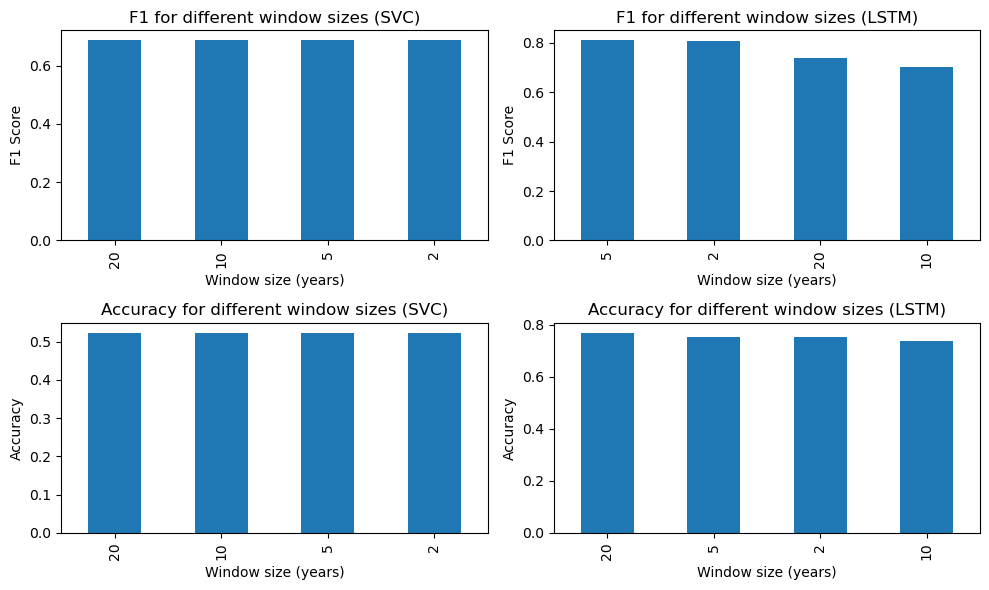

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

pd.DataFrame(svm_f1).T.sort_values(by=0, ascending=False).plot(kind='bar', legend=False,  figsize=(10,6), ax=axs[0, 0])
axs[0, 0].set_title('F1 for different window sizes (SVC)')
axs[0, 0].set_ylabel('F1 Score')
axs[0, 0].set_xlabel('Window size (years)')
axs[0, 0].tick_params(axis='x', labelrotation=90)
axs[0, 0].set_title('F1 for different window sizes (SVC)')
axs[0, 0].set_title

pd.DataFrame(lstm_f1).T.sort_values(by=0, ascending=False).plot(kind='bar', legend=False, figsize=(10,6), ax=axs[0, 1])
axs[0, 1].set_title('F1 for different window sizes (LSTM)')
axs[0, 1].set_ylaubel('F1 Score')
axs[0, 1].set_xlabel('Window size (years)')
axs[0, 1].tick_params(axis='x', labelrotation=90)

pd.DataFrame(svm_acc).T.sort_values(by=0, ascending=False).plot(kind='bar', legend=False, figsize=(10,6), ax=axs[1, 0])
axs[1, 0].set_title('Accuracy for different window sizes (SVC)')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_xlabel('Window size (years)')
axs[1, 0].tick_params(axis='x', labelrotation=90)

pd.DataFrame(lstm_acc).T.sort_values(by=0, ascending=False).plot(kind='bar', legend=False, figsize=(10,6), ax=axs[1, 1])
axs[1, 1].set_title('Accuracy for different window sizes (LSTM)')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_xlabel('Window size (years)')
axs[1, 1].tick_params(axis='x', labelrotation=90)

fig.tight_layout()
plt.show()

We note that the window size mainly affects the accuracy and F1 score of the LSTM network. Remarkably, less data improves the accuracy but decreases the F1 score for the LSTM network. The SVC is not as strongly affected by varying window sizes, probably because it is a less complex model (with less parameters) that is not in need of as much data as the LSTM is to train it properly. 

## 6. Conclusions

### 6.1 Performance Comparison

Let's collect all of the performances into one table

In [7]:
f1_results = pd.DataFrame({'SVM_PCA': [0.93], 'LSTM_PCA': [0.81], 'SVM_NO_PCA': [0.84], 'LSTM_NO_PCA': [0.96], 'MLP_PCA': [0.97], 'MLP_NO_PCA': [0.93]})
acc_results = pd.DataFrame({'SVM_PCA': [0.92], 'LSTM_PCA': [0.83], 'SVM_NO_PCA': [0.82], 'LSTM_NO_PCA': [0.95], 'MLP_PCA': [0.97], 'MLP_NO_PCA': [0.92]})

<Figure size 1000x600 with 0 Axes>

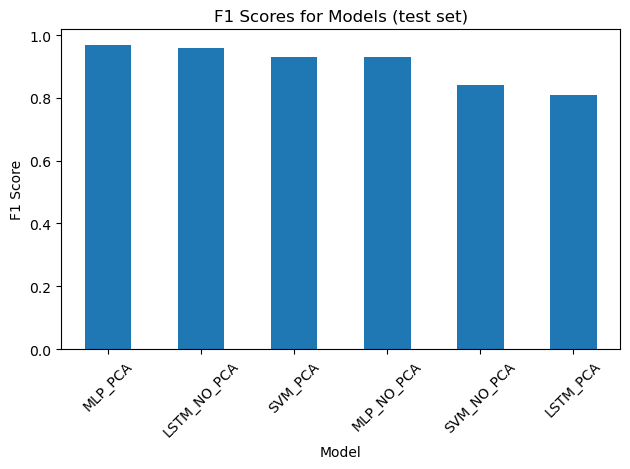

<Figure size 1000x600 with 0 Axes>

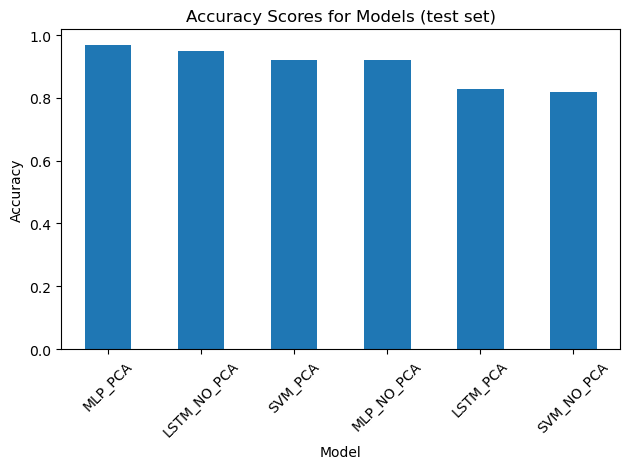

In [8]:
# Function to plot the results
def plot_results(df, title, ylabel):
    # Transpose the dataframe to make it suitable for bar plot
    df = df.T
    df.columns = ['Score']
    
    df.plot(kind='bar', legend=False)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to fit labels

# Sorting the results for plotting
f1_sorted = f1_results.T.sort_values(by=0, ascending=False)
acc_sorted = acc_results.T.sort_values(by=0, ascending=False)

# Plotting F1 Scores
plt.figure(figsize=(10, 6))
f1_sorted.plot(kind='bar', legend=False)
plt.title('F1 Scores for Models (test set)')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()

# Plotting Accuracy Scores
plt.figure(figsize=(10, 6))
acc_sorted.plot(kind='bar', legend=False)
plt.title('Accuracy Scores for Models (test set)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()

The following observations can be made:

- The overall best performer - both in terms of accuracy and F1 score -  is the MLP trained on the original PCA reduced training data.
- The LSTM's model performance strongly imprproves as more dimensions are available in the data (i.e. not using PCA). In the case of using the original data, the LSTM has thte strongest performance, achieveing an F1 score of 0.96
- The SVM performs best when applied to the PCA reduced data. In case of using the reduced data, the SVM almost outperforms the LSTM model, achieving an F1 score of 0.93.

#### Best Model's Performance

For completeness, the final scores for the best performing model (the MLP model trained on the PCA reduced data) are given below (cf. Section 3.3):

**Test set**: 

- Accuracy: 0.97
- F1 score: 0.97

*The accuracy and F1 score obtained on the trianing and validation set are not reported, as these will always be very high since the training+validation set is used as training set to assess the final performance of the model. Therefore, they give an incorrect image of performance. In section 3.3 the trianing procedure's accuracy can be seen.*

**Classification Report**
```
    precision    recall  f1-score   support

     Class 0       1.00      0.94      0.97        31
     Class 1       0.94      1.00      0.97        34

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65
```